# Nucleotide level interpretation of model at DNase HS sites

1. Comparison to SHARPR
2. Overlap with SiPhy conserved regions
3. Overlap with CENTIPEDE motifs
4. Average activities at motif instances, comparing cell types.
5. De novo motif discovery

In [1]:
import numpy as np
from glob import glob
import gzip
from sklearn.metrics import r2_score
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

In [2]:
def quantile_plot(data_pairs, quantiles = 5000, x = '', y = ''):
    data_pairs = sorted(data_pairs, key = lambda x: x[0])
    avg_activity, avg_score = [], []
    for i in range(0, len(data_pairs), len(data_pairs) / quantiles):
        index = range(i, min(i + (len(data_pairs) / quantiles), len(data_pairs)))
        activities = [data_pairs[j][0] for j in index]
        scores  = [data_pairs[j][1] for j in index]
        avg_activity.append(sum(activities) / float(len(activities)))
        avg_score.append(sum(scores) / float(len(scores)))
    i = 0
    while avg_activity[i] < 0: i += 1
    rho, pval = spearmanr(avg_activity[i:], avg_score[i:])
    print rho, pval
    plt.scatter(avg_activity, avg_score, s = 3, lw =0)
    plt.ylabel(y)
    plt.xlabel(x)
    plt.show()

In [29]:
def centipede(deep, c_f = '../../data/centipede/HEPG2_liftover.bed.gz', quants = 5000):
    hepG2_centipede = {}
    with gzip.open(c_f) as regions:
        regions.readline()
        for line in regions:
            chrom, start, end, motif = line.strip().split()[:4]
            start, end = int(start), int(end)
            if chrom not in hepG2_centipede: hepG2_centipede[chrom] = {}
            for pos in range(start, end):
                hepG2_centipede[chrom][pos] = motif
    deep_centipede = []
    for chrom, positions in deep.items():
        for pos, score in positions.items():
            motif = 1 if pos in hepG2_centipede[chrom] else 0
            deep_centipede.append((score, motif))
    quantile_plot(deep_centipede, quants,
              y = "Fraction overlapping Centipede TFBS",
              x = "Average DeepLIFT score")

In [30]:
def conserved(deep, quants = 5000):
    # Load in the data.
    si_phi = {} # chrom, position, LOR (no entry implies not signiticant)
    with gzip.open('../../data/conservation/hg19_29way_pi_lods_elements_12mers.chr_specific.fdr_0.1_with_scores.txt.gz') as conservation:
        for line in conservation:
            chrom, start, end, lor, branch = line.strip().split()
            start, end, lor = int(start), int(end), float(lor)
            if chrom not in deep: continue
            if chrom not in si_phi: si_phi[chrom] = {}
            if (start not in deep[chrom]
                and end not in deep[chrom]): continue
            for pos in range(start, end):
                si_phi[chrom][pos] = lor
            
    deep_conserve = []
    for chrom, positions in deep.items():
        for pos, score in positions.items():
            if chrom == 'chrY': continue
            deep_conserve.append((score, 1 if pos in si_phi[chrom] else 0))
        
    quantile_plot(deep_conserve, quants,
                  y = "Fraction overlapping conserved nucleotides",
                  x = "Average DeepLIFT score")


# HepG2-minP to HepG2 DNase Peaks

0.773700245841 0.0


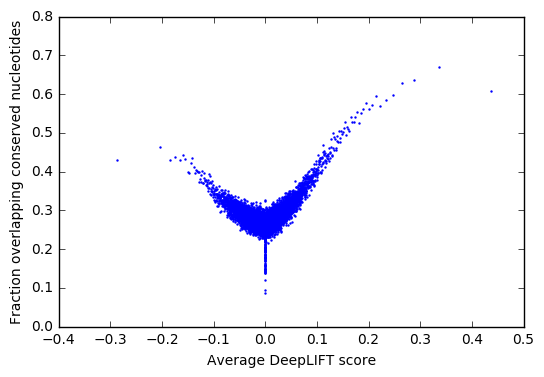

0.857567958453 0.0


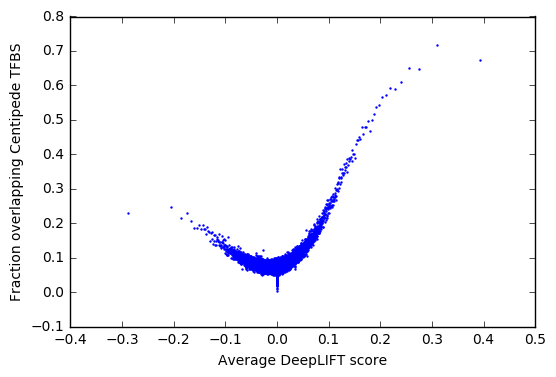

In [31]:
files = ['/mnt/dnase/hepg2_deeplift_20000.tsv.gz', '/mnt/dnase/hepg2_deeplift_40000.tsv.gz']
deep = {}
for fn in files:
    with gzip.open(fn) as fp:
        for line in fp:
            chrom, pos, score = line.strip().split()
            if chrom not in deep:
                deep[chrom] = {}
            deep[chrom][int(pos)] = float(score)
conserved(deep, quants = 10000)
centipede(deep, quants = 10000)

0.629068050866 0.0


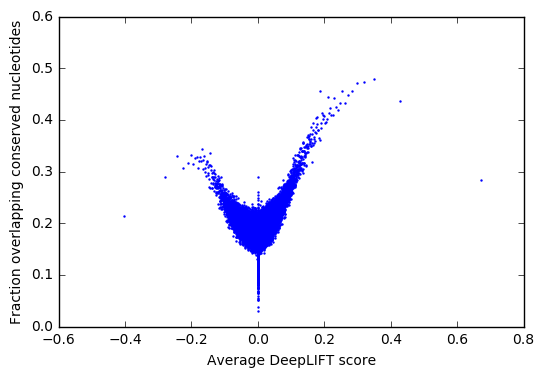

0.767729963937 0.0


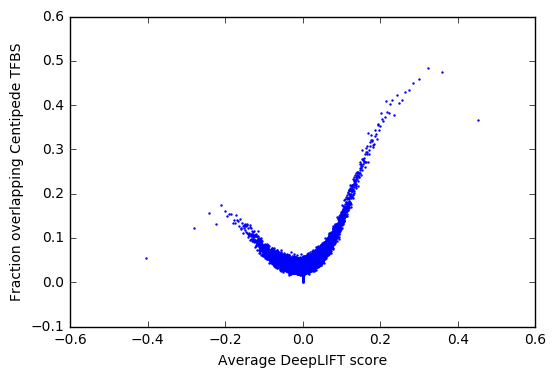

In [32]:
files = ['/mnt/dnase/hepg2_deeplift_20000.tsv.gz', '/mnt/dnase/hepg2_deeplift_40000.tsv.gz',
         '/mnt/dnase/hepg2_deeplift_60000.tsv.gz', '/mnt/dnase/hepg2_deeplift_80000.tsv.gz',
         '/mnt/dnase/hepg2_deeplift_100000.tsv.gz', '/mnt/dnase/hepg2_deeplift_120000.tsv.gz',
         '/mnt/dnase/hepg2_deeplift_140000.tsv.gz', '/mnt/dnase/hepg2_deeplift_160000.tsv.gz',
         '/mnt/dnase/hepg2_deeplift_180000.tsv.gz', '/mnt/dnase/hepg2_deeplift_200000.tsv.gz']
deep = {}
for fn in files:
    with gzip.open(fn) as fp:
        for line in fp:
            chrom, pos, score = line.strip().split()
            if chrom not in deep:
                deep[chrom] = {}
            deep[chrom][int(pos)] = float(score)
conserved(deep, quants = 50000)
centipede(deep, quants = 50000)

# HepG2 to k562 DNase Peaks

In [ ]:
files = ['/mnt/dnase/hepg2_deeplift_20000.tsv.gz']
deep = {}
for fn in files:
    with gzip.open(fn) as fp:
        for line in fp:
            chrom, pos, score = line.strip().split()
            if chrom not in deep:
                deep[chrom] = {}
            deep[chrom][int(pos)] = float(score)
conserved(deep)
centipede(deep)

In [ ]:
files = ['/mnt/dnase/hepg2_deeplift_20000.tsv.gz', '/mnt/dnase/hepg2_deeplift_40000.tsv.gz']
deep = {}
for fn in files:
    with gzip.open(fn) as fp:
        for line in fp:
            chrom, pos, score = line.strip().split()
            if chrom not in deep:
                deep[chrom] = {}
            deep[chrom][int(pos)] = float(score)
conserved(deep)
centipede(deep)

In [ ]:
files = ['/mnt/dnase/hepg2_deeplift_20000.tsv.gz', '/mnt/dnase/hepg2_deeplift_40000.tsv.gz',
         '/mnt/dnase/hepg2_deeplift_60000.tsv.gz', '/mnt/dnase/hepg2_deeplift_80000.tsv.gz',
         '/mnt/dnase/hepg2_deeplift_100000.tsv.gz', '/mnt/dnase/hepg2_deeplift_120000.tsv.gz',
         '/mnt/dnase/hepg2_deeplift_140000.tsv.gz', '/mnt/dnase/hepg2_deeplift_160000.tsv.gz',
         '/mnt/dnase/hepg2_deeplift_180000.tsv.gz', '/mnt/dnase/hepg2_deeplift_200000.tsv.gz']
deep = {}
for fn in files:
    with gzip.open(fn) as fp:
        for line in fp:
            chrom, pos, score = line.strip().split()
            if chrom not in deep:
                deep[chrom] = {}
            deep[chrom][int(pos)] = float(score)
conserved(deep)
centipede(deep)

# Comparison to SHARPR

In [12]:
# Loads in SHARPR activity scores
sharpr = {}
for promoter in ('minP',):
    for cell_type in ('HEPG2',):
        experiment_key = (promoter, cell_type)
        sharpr[experiment_key] = {}
        with open("../../data/sharpr_scores/wig/{}_{}.wig".format(promoter, cell_type)) as wig:
            for line in wig:
                if line[0] == '#': continue
                chrom, start, end, score = line.strip().split()
                start, end = int(start), int(end)
                score = float(score)
                if end - start > 1: continue
                if chrom not in sharpr[experiment_key]: sharpr[experiment_key][chrom] = {}
                for pos in range(start, end):
                    assert pos not in sharpr[experiment_key][chrom]
                    sharpr[experiment_key][chrom][pos] = score
sharpr = sharpr[sharpr.keys()[0]]

10065956
0.112024832675 0.0


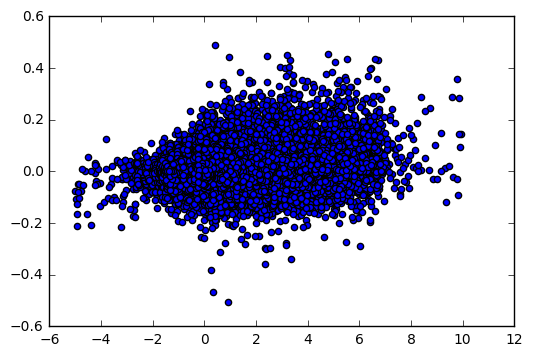

0.558422579046 2.2326810469e-267


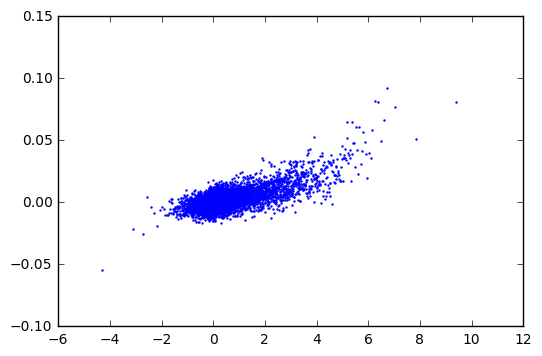

In [13]:
from sklearn.metrics import r2_score
from scipy.stats import spearmanr
s, d = [], []
pairs = []
missing = 0
for chrom, positions in deep.items():
    for pos, score in positions.items():
        try:
            s += [sharpr[chrom][int(pos)]]
            d += [score]
            pairs += [(s[-1], d[-1])]
        except KeyError:
            missing += 1
print missing
rho, pval = spearmanr(s, d)
print rho, pval
plt.scatter(s, d)
#plt.plot(np.unique(s), np.poly1d(np.polyfit(s, d, 1))(np.unique(s)), c='r', linewidth=3)
plt.show()
quantile_plot(pairs, 5000)

0.112024832675 0.0


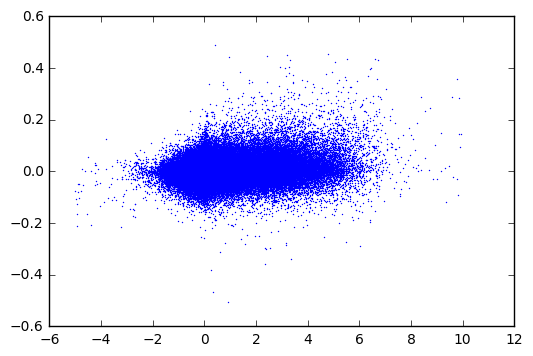

0.558422579046 2.2326810469e-267


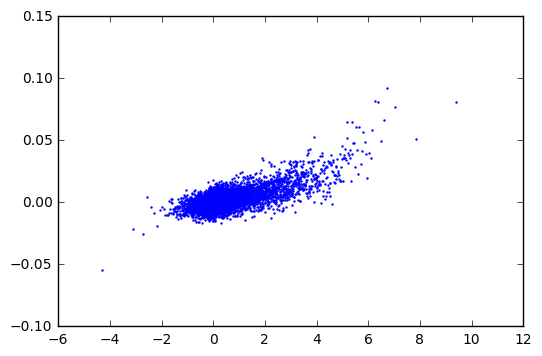

In [14]:
rho, pval = spearmanr(s, d)
print rho, pval
plt.scatter(s, d, lw = 0, s = 1)
#plt.plot(np.unique(s), np.poly1d(np.polyfit(s, d, 1))(np.unique(s)), c='r', linewidth=3)
plt.show()
quantile_plot(pairs, 5000)

In [15]:
phastcons = {}
with open('phastcons.csv') as fp:
    for line in fp:
        chrom, pos, score = line.strip().split(' ')
        if chrom not in phastcons:
            phastcons[chrom] = {}
        phastcons[chrom][int(pos)] = score
        

chr10	123822905	123822920


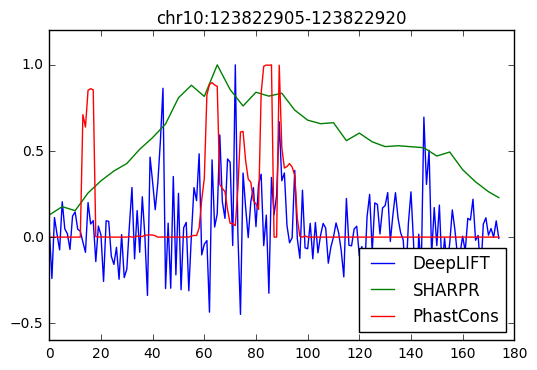

chr15	74890743	74890769


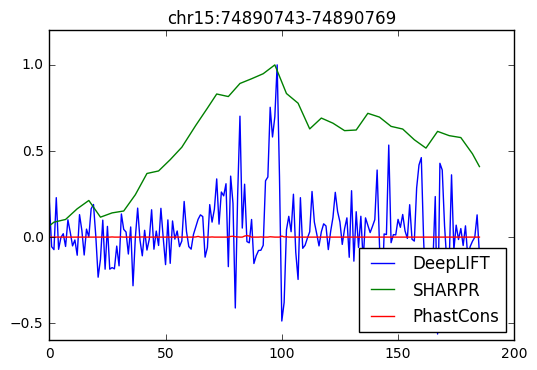

chr10	124913738	124913751


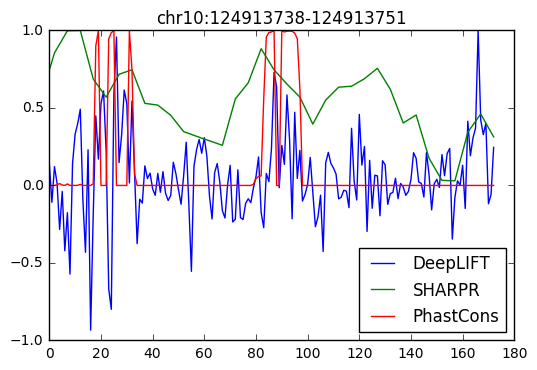

chr15	74890754	74890767


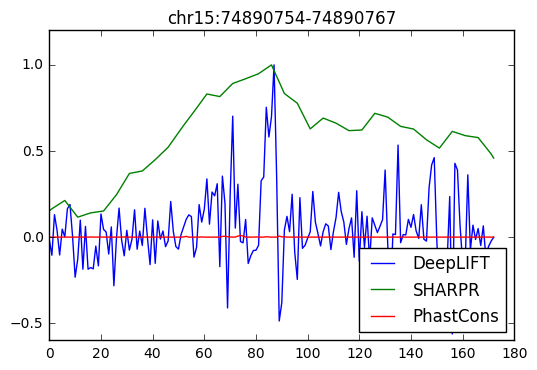

chr1	118472262	118472272


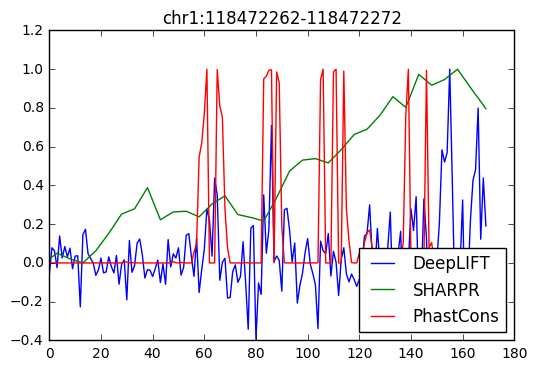

chr10	123822887	123822895


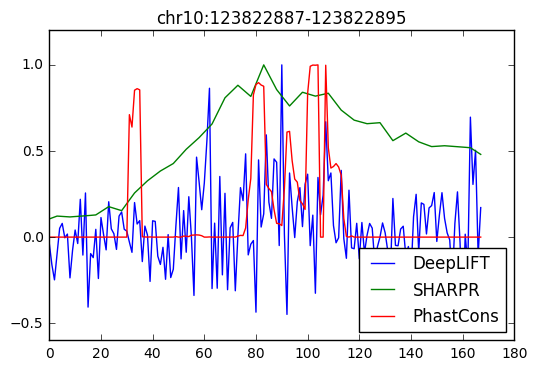

chr14	94492606	94492621


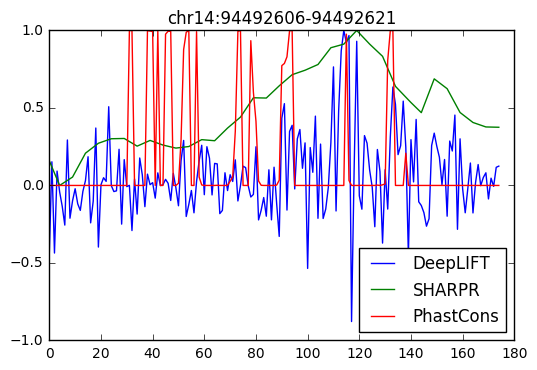

chr15	74890753	74890768


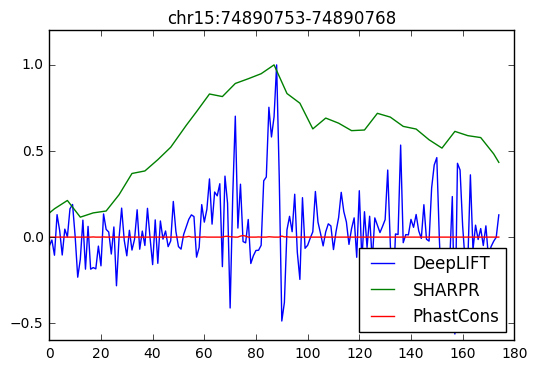

chr1	118472260	118472275


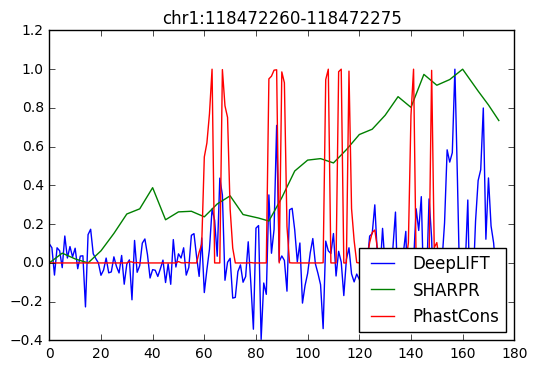

chr15	74890771	74890786


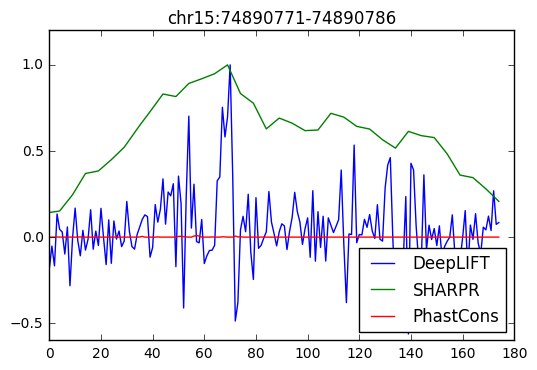

chr15	74890755	74890764


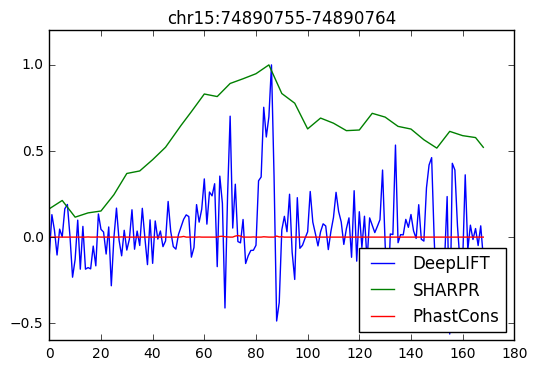

chr15	74890756	74890766


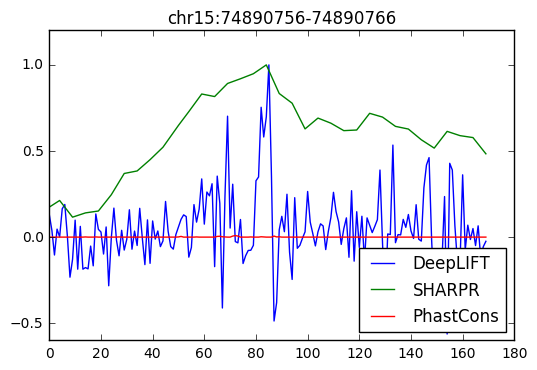

chr15	74890750	74890761


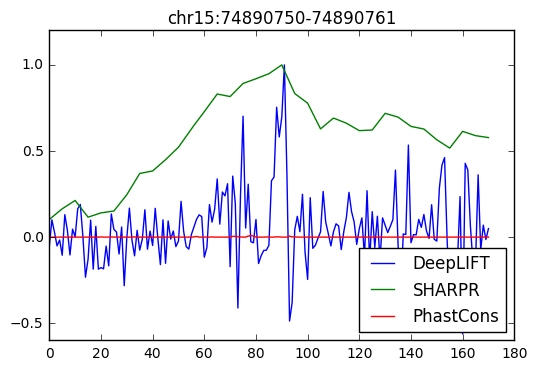

chr10	123822909	123822918


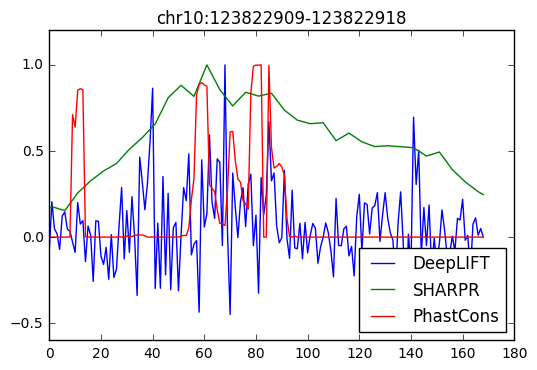

chr15	74890739	74890751


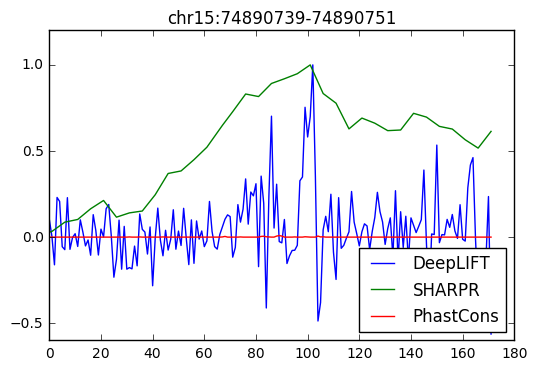

chr15	74890754	74890767


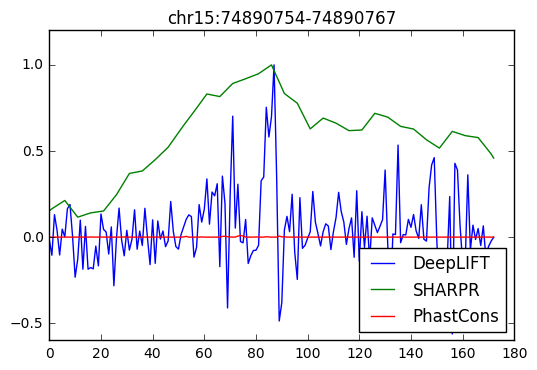

chr10	124913741	124913750


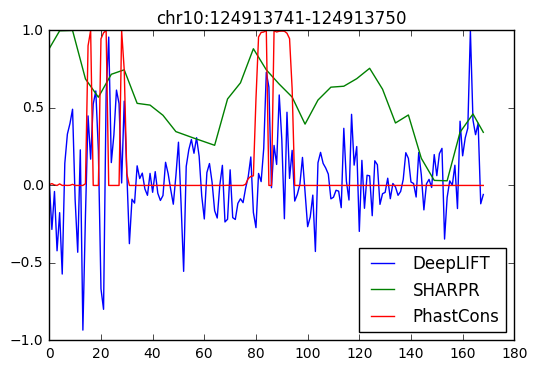

chr1	118472260	118472275


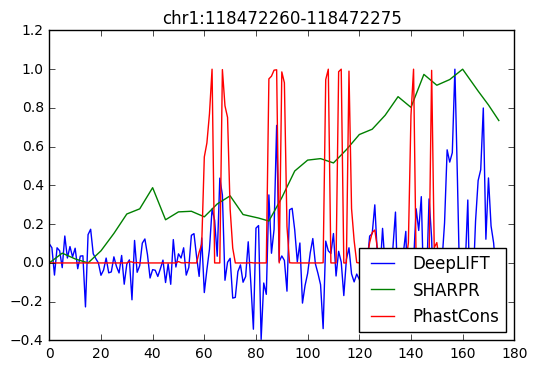

chr15	74890771	74890786


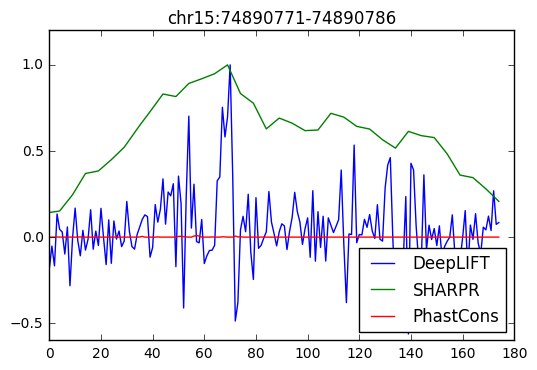

chr1	118472264	118472278


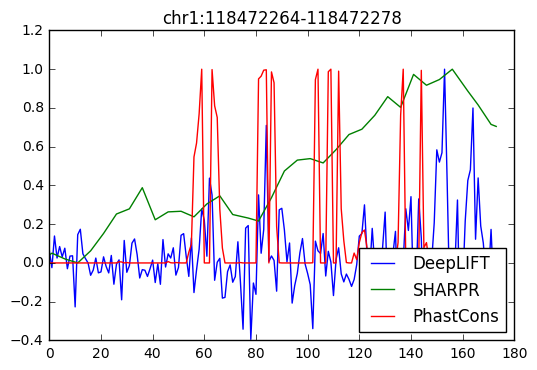

chr14	94492651	94492665


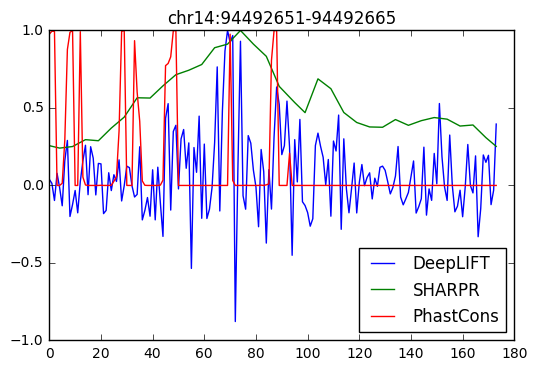

chr10	124913742	124913748


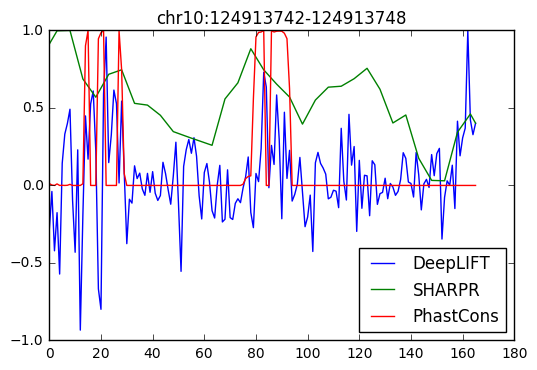

chr14	94492611	94492617


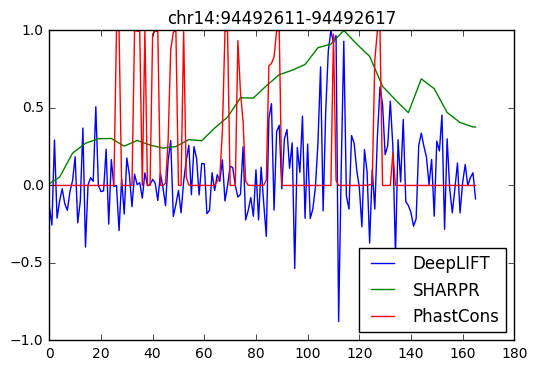

chr15	74890757	74890763


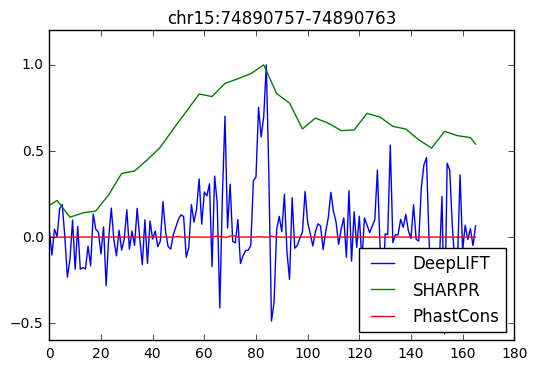

chr15	74890756	74890765


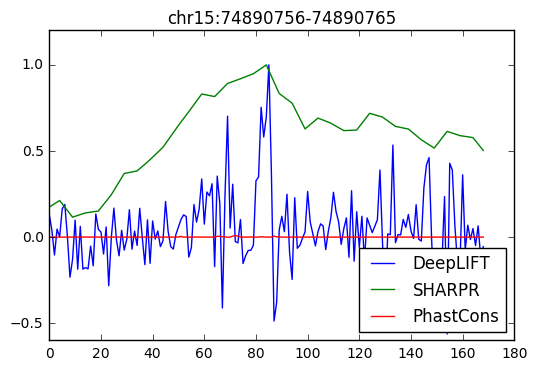

chr15	74890784	74890797


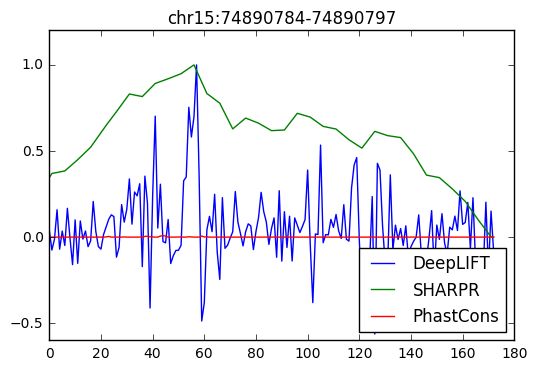

chr1	118472331	118472338


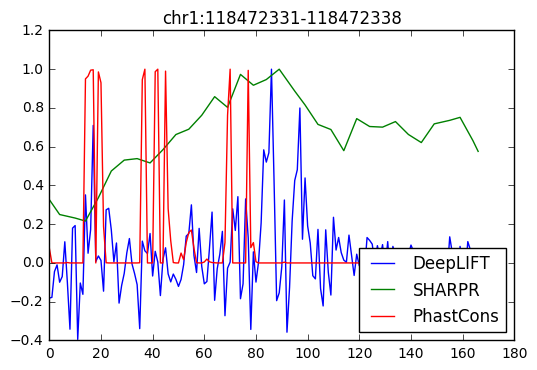

chr10	124913676	124913688


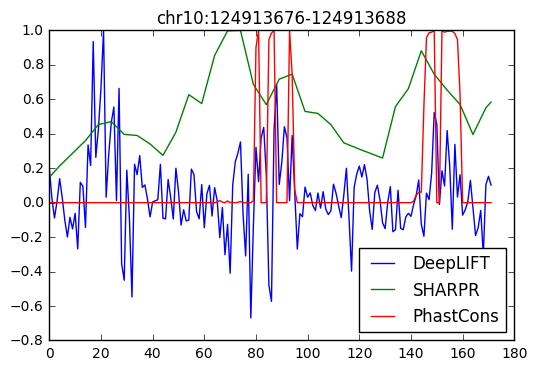

In [16]:
with gzip.open('../../data/centipede/HEPG2_liftover.bed.gz') as regions:
    regions.readline()
    count = 0
    for line in regions:
        chrom, start, end, motif = line.strip().split()[:4]
        start, end = int(start), int(end)
        #if chrom not in sharpr or chrom not in deep: continue
        #if start-50 not in sharpr[chrom] or start-50 not in deep[chrom]: continue
        #if end+50 not in sharpr[chrom] or end+50 not in deep[chrom]: continue
        try:
            d = [deep[chrom][pos] for pos in range(start - 80, end + 80)]
            s = [sharpr[chrom][pos] for pos in range(start - 80, end + 80)]
            conserve = [phastcons[chrom][pos] if pos in phastcons[chrom] else 0 for pos in range(start - 80, end + 80)]
            #print conserv
            print chrom + '\t' + str(start) + '\t' + str(end)
            plt.title("{}:{}-{}".format(chrom, start, end))
            plt.plot(map(lambda x: x / max(d), d), label = "DeepLIFT")
            plt.plot(map(lambda x: x / max(s), s), label = "SHARPR")
            plt.plot(conserve, label = "PhastCons")
            plt.legend(loc='lower right')
            plt.show()
            #count += 1
            #if count > 50: break
            
        except KeyError:
            pass

In [35]:
chrom = 'chr4'
print len(deep[chrom])
count = 0
for pos in range(10000, 20000000):
    try:
        d = [deep[chrom][pos] for pos in range(start - 80, end + 80)]
        s = [sharpr[chrom][pos] for pos in range(start - 80, end + 80)]

        plt.plot(map(lambda x: x / max(d), d))
        plt.plot(map(lambda x: x / max(s), s))
        plt.show()
        count += 1
        if count > 50: break
    except KeyError:
        pass

63184


KeyboardInterrupt: 

# Comparison to ENCODE motifs

In [63]:
encode = {}
with gzip.open('/mnt/matches.txt.gz') as regions:
    for i, line in enumerate(regions):
        motif, chrom, start, end, strand = line.strip().split()
        start, end = int(start), int(end)
        if chrom not in encode: encode[chrom] = {}
        if chrom not in deep: continue
        if start not in deep[chrom]: continue
        for pos in range(start, end):
            if pos not in encode[chrom]: encode[chrom][pos] = set()
            encode[chrom][pos].add(motif)

KeyboardInterrupt: 

In [64]:
deep_encode = []
for chrom, positions in deep.items():
    for pos, score in positions.items():
        if chrom == 'chrY': continue
        motif = 1 if pos in encode[chrom] else 0
        deep_encode.append((score, motif))

KeyError: 'chrX'

In [ ]:
quantile_plot(deep_encode, 10000)